In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import time

C:\Users\ali\AppData\Local\Temp\ipykernel_6004\3952593290.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
## !! CHANGE ME !! ##
os.chdir('C:\\ali\\packages\\s2p-lbm')
from suite2p.io import lbm as lbmio
from suite2p.suite3d import utils
from utils import tiff_utils as tfu
from suite2p.suite3d.job import Job

C:\Users\ali\anaconda3\envs\s2p-lbm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Find all the tiffiles in the tif path
tif_path = r'Y:\\runs\\Coconut'
tifs = tfu.get_tif_paths(tif_path)

In [4]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 0.1
}

In [5]:
# Create the job
job = Job('Y:\\runs\\Coconut','Coconut-Demo', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

Job directory Y:\runs\Coconut\s3d-Coconut-Demo already exists
Loading job directory for Coconut-Demo in Y:\runs\Coconut
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param fs
      Updating param planes
      Updating param tau
   Updated main params file


In [6]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 1
job.params['init_n_frames'] = 800

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None

In [7]:
# job.run_init_pass()

In [8]:
summary = job.load_summary()

(-100.0, 100.0)

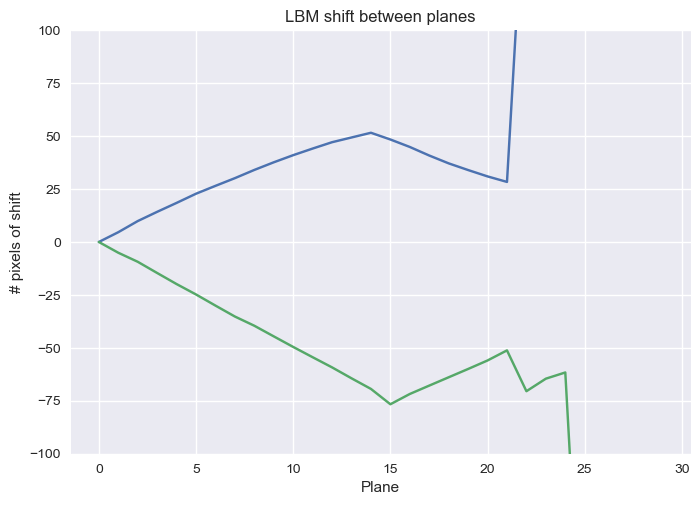

In [9]:
summary = job.load_summary()
plt.plot(summary['plane_shifts'])
plt.xlabel("Plane")
plt.ylabel("# pixels of shift")
plt.title("LBM shift between planes")
plt.ylim(-100,100)

In [10]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [11]:
# job.register()

In [12]:
# FUSING: fuse the strips from the FOV into one image
# this is the number of pixels to skip between pixels, 13 makes it look relatively smooth
job.params['n_skip'] = 13
# should only fuse files where the plane_shifts look good, otherwise you might get an error
job.params['fuse_crop'] = ((0,22), (0,584), (0,584))

In [13]:
# files = job.get_registered_files()
# fused = job.fuse_registered_movie(files=files, save=True, n_proc = 8,
#                                   delete_original=False)

In [128]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:1000].mean(axis=1).compute()

In [14]:
job.params['n_svd_comp'] = 1000
job.params['svd_crop'] = ((0,22), (55,584), (0, 460))
job.params['svd_time_crop'] = (None,None)
job.params['svd_block_shape'] = (4,200,200)
job.params['svd_block_overlaps'] = (1,50,50)
job.params['svd_pix_chunk'] = None
job.params['n_svd_blocks_per_batch'] = 4
svd_dir_tag = 'svd_cropped'

In [15]:
# tic = time.time()
# job.make_new_dir(svd_dir_tag)
# svd_info = job.svd_decompose_movie(svd_dir_tag, run_svd=True)
# svd_toc = time.time() - tic

In [16]:
svd_info = n.load(os.path.join(job.dirs['svd_cropped'], 'svd_info.npy'),allow_pickle=True).item()

In [17]:
job.params['npil_filt_type'] = 'gaussian'
job.params['npil_filt_xy'] = 5.0
job.params['npil_filt_z'] = 1.0
job.params['conv_filt_type'] = 'gaussian'
job.params['conv_filt_xy'] = 1.0
job.params['conv_filt_z'] = 0.75
job.params['temporal_hpf'] = 400
job.params['t_batch_size'] = 400
job.params['mproc_batchsize'] = 50
job.params['n_proc_corr'] = 8
job.params['n_svd_comps'] = 200
job.params['intensity_thresh'] = 0.25

In [23]:
params_to_sweep = {
    'npil_filt_xy' : (5.0,),
    'conv_filt_xy' : (1.0,),
    'intensity_thresh' : (0.25, 0.4),
    'n_svd_comps' : (200, 350, 500),
}


In [24]:
summary = job.sweep_params(params_to_sweep, svd_info,testing_dir_tag='sweep-vmap-params-2',
                           do_vmap=True, all_combinations=True, n_test_iters = 1)

      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2 with tag sweep-vmap-params-2
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00000 with tag sweep-vmap-params-2-comb_00000
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00001 with tag sweep-vmap-params-2-comb_00001
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00002 with tag sweep-vmap-params-2-comb_00002
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00003 with tag sweep-vmap-params-2-comb_00003
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00004 with tag sweep-vmap-params-2-comb_00004
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00005 with tag sweep-vmap-params-2-comb_00005
   Saving summary for 6 combinations to Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2\sweep_summary.npy
   Running combination 01/06
      Combination params: comb00000-params-npil_

         Reconstructed in 86.77 seconds
      Loaded and swapped, idx 0 to 400
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\sweep-vmap-params-2-comb_00005\iters\batch0000


In [25]:
v = job.vis_vmap_sweep(summary)

[1, 1, 2, 3]
(1, 1, 2, 3, 22, 529, 460)


In [18]:
job.params['intensity_thresh'] = 0.4
job.params['n_svd_comps'] = 350
job.params['conv_filt_xy'] = 1.0
job.params['npil_filt_xy'] = 5.0

In [19]:
job.calculate_corr_map(svd_info)

   Updated main params file
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\mov_sub with tag mov_sub
   Saving mov_sub to Y:\runs\Coconut\s3d-Coconut-Demo\mov_sub
   Using conv_filt: gaussian, 0.75, 1.00
   Using np_filt: gaussian, 1.00, 5.00
   Will reconstruct SVD movie on-the-fly from Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped with 350 components
   Created files and dirs for 25 batches
      Running batch 1 of 25
         Reconstructing from svd
         Reconstructed in 80.86 seconds
      Loaded and swapped, idx 0 to 400
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0000
      Running batch 2 of 25
         Reconstructing from svd
         Reconstructed in 79.62 seconds
      Loaded and swapped, idx 400 to 800
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Su

OSError: 2141392000 requested and 1610612736 written